In [1]:
from dataloaders import gather_static_graphs
import dgl
from dgl.data import DGLDataset
import torch
import os
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np

Using backend: pytorch


In [2]:
import torch.nn as nn
from dgl.nn import GraphConv # GCN
import torch.nn.functional as F
from sklearn import metrics
import torch.nn as nn
import torch.optim
from pytorch_lightning import LightningModule
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn import functional as F
from torch_scatter import scatter_add
from torch.nn import ReLU

from torch_geometric.nn import GCNConv

In [3]:
data_file = 'LA_DATA_2018_02_to_2018_06.csv'
# node_cols = 'visibility', 'precipitation_depth']
node_cols = ['wind_x', 'wind_y', 'temperature', 'pressure', 'ceiling', 'dew', 'precipitation_duration' , 'mean_aod','min_aod','max_aod', 'pm25']                                                 
edge_cols = ['wind_x', 'wind_y']
dist_thresh = 30e6
use_self_loops = True
multi_edge_feature = False

graph_states_loader, graph =  gather_static_graphs(data_file,
                                                    edge_cols,
                                                    node_cols, 
                                                    dist_thresh,
                                                    multi_edge_feature,
                                                    use_self_loops)


Found Checkpoint, loading


In [4]:
for i, (nf, ef, l) in enumerate(graph_states_loader): 
    if i ==1: 
        labels = l
    if i ==1: 
        node_features = nf
        edge_features = ef
    

In [5]:
class MaskedGraphDataset(DGLDataset):
    def __init__(self, 
                node_features,
                edge_features,
                labels, 
                graph, 
                train_test_split = 0.9):

        self.node_features = node_features.squeeze()
        self.edge_features = edge_features.squeeze()
        self.labels = labels.squeeze()
        self.edge_src, self.edge_dst = graph.edge_index
        self.train_test_split = train_test_split
        super().__init__(name = 'MaskedPollutionGraph')

    def process(self):

        self.edge_src = torch.tensor(self.edge_src)
        self.edge_dst = torch.tensor(self.edge_dst)

        n_nodes = self.node_features.shape[0]

        self.graph = dgl.graph((self.edge_src, self.edge_dst), num_nodes=n_nodes)
        self.graph.ndata['feat'] = self.node_features.float()
        self.graph.ndata['label'] = self.labels.float()
        self.graph.edata['weight'] = self.edge_features.float()

        n_train = int(n_nodes * self.train_test_split)
        n_val = n_nodes - n_train
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)

        train_mask[:n_train] = True
        val_mask[n_train:] = True

        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask

        mask = self.graph.ndata['train_mask']
        masked_idx = torch.argwhere(~mask).flatten()
        training_masked_dst = self.edge_src[self.edge_src != masked_idx]
        training_masked_src = self.edge_dst[self.edge_dst != masked_idx]
        self.edge_index = torch.LongTensor(torch.stack([self.edge_src, self.edge_dst]))
        self.training_masked_edge_index = torch.LongTensor(torch.stack([training_masked_src, training_masked_dst]))

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [6]:
class GCN(nn.Module):
    def __init__(self, input_dim, dropout = 0.3):
        super(GCN, self).__init__()
        self.h1 = 16
        self.h2 = 10
        self.conv1 = GraphConv(input_dim, self.h1)
        self.conv2 = GraphConv(self.h1, self.h2)
        self.conv3 = GraphConv(self.h2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, x):
        x = self.conv1(g, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(g, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(g, x)
        return x


class EdgeGNN(nn.Module):
    def __init__(self, in_dim, dropout):
        super(EdgeGNN, self).__init__()

        e_h = 16
        e_out = 16
        n_out = 1
        e_h2 = 16
        n_h = 12

        self.edge_mlp = Sequential(Linear(in_dim, e_h),
                                   nn.Dropout(dropout),                                   
                                   ReLU(),
                                   Linear(e_h, e_h2),
                                   nn.Dropout(dropout),                                  
                                   ReLU(),
                                   Linear(e_h2, e_out),
                                   Sigmoid(),
                                   )
        self.node_mlp = Sequential(Linear(e_out, n_h),
                                   nn.Dropout(dropout),       
                                   ReLU(),
                                   Linear(n_h, n_out),
                                   Sigmoid(),
                                   )

    def forward(self, edge_index,  node_features, edge_features):
        """
        x = (node_features, edge_features)
        """
        edge_src, edge_target = edge_index
        node_src = node_features[:, edge_src]
        node_target = node_features[:, edge_target]

        out = torch.cat([node_src, node_target, edge_features.unsqueeze(-1)], dim=-1).float()

        out = self.edge_mlp(out)
        out_add = scatter_add(out, edge_target, dim=1, dim_size=node_features.size(1))
        out_sub = scatter_add(out.neg(), edge_src, dim=1, dim_size=node_features.size(1))  # For higher version of PyG.

        out = out_add + out_sub
        out = self.node_mlp(out)
        return out

In [7]:
def train_on_graph(graph_dataset,
                   model,
                   device,
                   epochs, 
                   criterion, 
                   log = True, 
                   ):

    graph = graph_dataset[0]
    g = graph.to(device)

    edge_idx = graph_dataset.edge_index

    node_features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    edge_features = g.edata['weight']
    train_mask, val_mask = train_mask.squeeze(), val_mask.squeeze()
    
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)

    train_losses, val_losses = [], []
    train_errors, val_errors = [], []

    for epoch in range(epochs):
    
        model.train()
        if isinstance(model, EdgeGNN):
            output = model(edge_idx, node_features.unsqueeze(0), edge_features.unsqueeze(0))
        elif isinstance(model, GCN):
            output = model(g, node_features) 
            
        output, train_labels = output.squeeze(), labels.squeeze()
        output, train_labels = output[train_mask], train_labels[train_mask]
        loss = criterion(output, train_labels) # use only training nodes for the loss

        train_percent_error = torch.abs(output - train_labels) / train_labels
        train_errors.append(np.mean(train_percent_error.detach().numpy()))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            if isinstance(model, EdgeGNN):
                output = model(edge_idx, node_features.unsqueeze(0), edge_features.unsqueeze(0))
            elif isinstance(model, GCN):
                output = model(g, node_features) 
            output, labels = output.squeeze(), labels.squeeze()
            output = output[val_mask]
            val_labels = labels[val_mask]
        val_loss = criterion(output, val_labels)
        val_loss = val_loss.item()
        val_losses.append(val_loss)

        val_percent_error = torch.abs(output - val_labels) / val_labels
        val_errors.append(np.mean(val_percent_error.detach().numpy()))


        if log: 
            if epoch % 10 == 0: 
                print(f'Epoch: {epoch+1} | Train loss: {train_loss} | Val Loss: {val_loss}')

    
    return train_losses,  val_losses, train_errors, val_errors

        
       
        

In [8]:
graph_dataset = MaskedGraphDataset(node_features, edge_features, labels, graph)
G = graph_dataset[0]

input_dim = G.ndata['feat'].shape[1]
hidden_dim = 8
output_dim = 1
criterion = nn.L1Loss()



# model = GCN(input_dim, hidden_dim, output_dim)
model = GCN(input_dim, dropout = 0.3)


# input_dim = 23
# model = EdgeGNN(input_dim, dropout = 0.2)

train_losses,  val_losses, train_errors, val_errors = train_on_graph(graph_dataset, model, 'cpu', 100, criterion, log = False)

best_epochs = np.argmin(val_losses)

model = GCN(input_dim, dropout = 0.3)
train_losses,  val_losses, train_errors, val_errors = train_on_graph(graph_dataset, model, 'cpu', best_epochs, criterion)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: 1 | Train loss: 21.947805404663086 | Val Loss: 39.11944580078125
Epoch: 11 | Train loss: 20.547569274902344 | Val Loss: 37.67634963989258
Epoch: 21 | Train loss: 18.690439224243164 | Val Loss: 36.08367919921875
Epoch: 31 | Train loss: 17.16132926940918 | Val Loss: 34.22532653808594
Epoch: 41 | Train loss: 14.818164825439453 | Val Loss: 32.12138366699219
Epoch: 51 | Train loss: 13.347864151000977 | Val Loss: 29.92734146118164


In [9]:
np.argmin(val_losses)

57

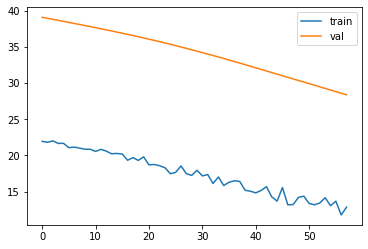

In [10]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()

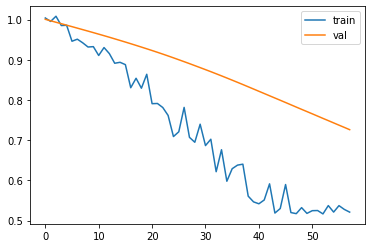

In [11]:

import matplotlib.pyplot as plt
plt.plot(train_errors, label = 'train')
plt.plot(val_errors, label = 'val')
plt.legend()

In [56]:
unlabelled = pd.read_csv('data/la_train_grid_with_weather.csv')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [57]:
data_file = 'LA_DATA_2018_02_to_2018_06.csv'
# node_cols = 'visibility', 'precipitation_depth']
node_cols = ['wind_x', 'wind_y', 'temperature', 'pressure', 'ceiling', 'dew', 'precipitation_duration' , 'mean_aod','min_aod','max_aod', 'pm25']                                                 
edge_cols = ['wind_x', 'wind_y']
dist_thresh = 30e6
use_self_loops = True
multi_edge_feature = False

graph_states_loader, graph =  gather_static_graphs(data_file,
                                                    edge_cols,
                                                    node_cols, 
                                                    dist_thresh,
                                                    multi_edge_feature,
                                                    use_self_loops, 
                                                    pseudo_data = True)


,day,wkt,mean_aod,min_aod,max_aod,Latitudes,Longitudes,STATION,wind_x,wind_y,ceiling,visibility,temperature,pressure,dew,precipitation_duration,precipitation_depth,dist
0,2018-02-01,POLYGON ((-118.18086152883222 33.7020803924213...,0.151435,0.117,0.193,-118.225777,33.664840,99403599999,NaN,NaN,NaN,999999.00000,NaN,10150.29167,NaN,NaN,NaN,5.902901
1,2018-02-02,POLYGON ((-118.18086152883222 33.7020803924213...,0.142000,0.103,0.198,-118.225777,33.664840,99403599999,NaN,NaN,NaN,999999.00000,NaN,10178.62500,NaN,NaN,NaN,5.902901
2,2018-02-03,POLYGON ((-118.18086152883222 33.7020803924213...,0.097443,0.066,0.147,-118.225777,33.664840,99403599999,NaN,NaN,NaN,999999.00000,NaN,10185.12500,NaN,NaN,NaN,5.902901
3,2018-02-04,POLYGON ((-118.18086152883222 33.7020803924213...,0.098783,0.068,0.138,-118.225777,33.664840,99403599999,NaN,NaN,NaN,999999.00000,NaN,10172.12500,NaN,NaN,NaN,5.902901
4,2018-02-05,POLYGON ((-118.18086152883222 33.7020803924213...,0.140263,0.103,0.435,-118.225777,33.664840,99403599999,NaN,NaN,NaN,999999.00000,NaN,10154.95833,NaN,NaN,NaN,5.902901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469650,2020-12-25,POLYGON ((-117.19271471630032 34.2234442399502...,0.057128,0.024,0.119,-117.237630,34.186204,72286699999,18.794820,15.757901,21012.46154,15474.02564,10.823077,NaN,20.162162,NaN,NaN,4.633505
469651,2020-12-26,POLYGON ((-117.19271471630032 34.2234442399502...,0.047577,0.019,0.105,-117.237630,34.186204,72286699999,76.872744,-10.518798,20896.33333,15556.55556,11.363889,NaN,-4.305556,NaN,NaN,4.633505
469652,2020-12-29,POLYGON ((-117.19271471630032 34.2234442399502...,0.326000,0.260,0.360,-117.237630,34.186204,72286699999,-8.882867,-0.025002,15052.78049,14522.95122,7.339024,NaN,21.804878,NaN,NaN,4.633505
469653,2020-12-30,POLYGON ((-117.19271471630032 34.2234442399502...,0.130757,0.110,0.157,-117.237630,34.186204,72286699999,30.748846,2.748984,22000.00000,15474.02564,13.289744,NaN,-80.473684,NaN,NaN,4.633505


In [ ]:
'''
1. Integrate pseudolabels into dataloaders of graph
2. Train model
3. Infer pseudolabels 
4. Save results properly
5. Integrate results into code
'''